In [36]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
data = pd.read_csv('housing.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# Clean data
data.dropna(inplace=True)

In [5]:
# Define X,y
X=data.drop(['median_house_value'],axis=1)
y=data['median_house_value']

In [12]:
X = X.join(pd.get_dummies(X['ocean_proximity']))

In [13]:
X.drop(['ocean_proximity'],axis=1,inplace=True)

In [14]:
# Split data
from sklearn.model_selection import train_test_split
random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>,
        <AxesSubplot:title={'center':'total_rooms'}>],
       [<AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>,
        <AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>],
       [<AxesSubplot:title={'center':'<1H OCEAN'}>,
        <AxesSubplot:title={'center':'INLAND'}>,
        <AxesSubplot:title={'center':'ISLAND'}>,
        <AxesSubplot:title={'center':'NEAR BAY'}>],
       [<AxesSubplot:title={'center':'NEAR OCEAN'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

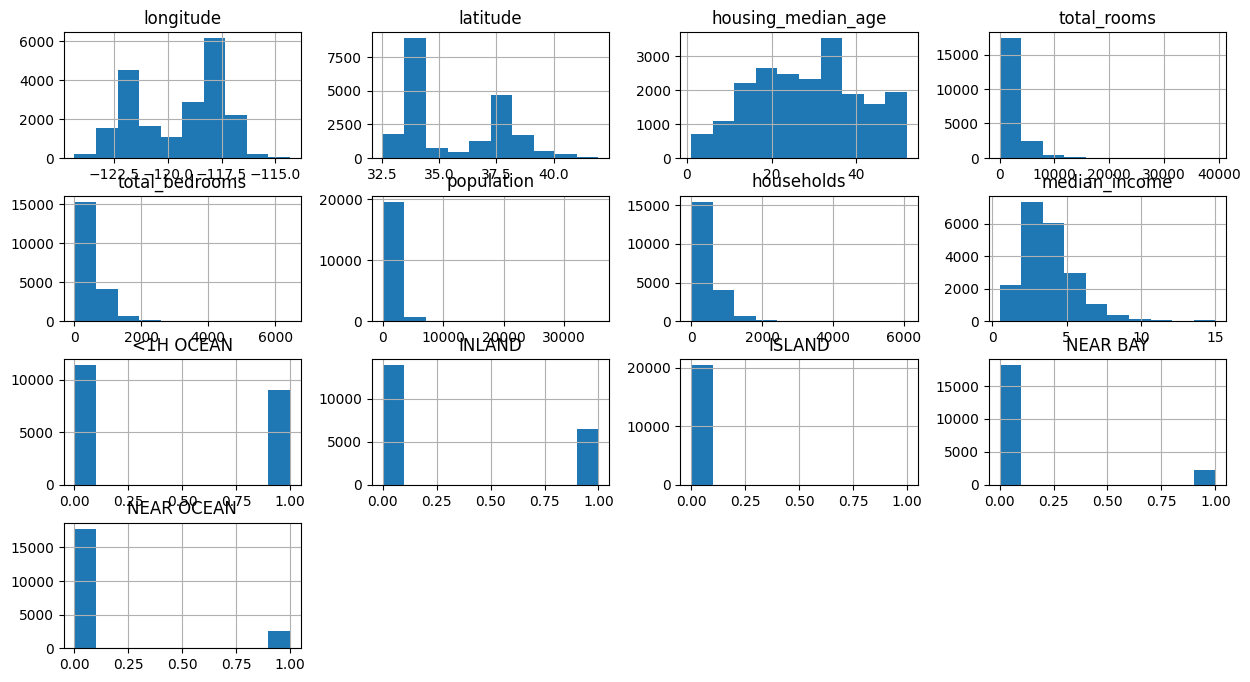

In [10]:
X.hist(figsize=(15,8))

### Feature engineering

In [6]:
# Log transform data to address skewness distribution
X['total_bedrooms'] = np.log(X['total_bedrooms']+1)
X['total_rooms'] = np.log(X['total_rooms']+1)
X['population'] = np.log(X['population']+1)
X['households'] = np.log(X['households']+1)


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

## Linear Regression

In [8]:
# Define model
lm=LinearRegression()

In [15]:
lm.fit(X_train,y_train)

LinearRegression()

In [16]:
input = [('scale',StandardScaler()),('model',LinearRegression())]

In [17]:
pipe = Pipeline(input)

In [18]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()), ('model', LinearRegression())])

In [19]:
lm.score(X_test,y_test)

0.6683603521371759

In [37]:
y_pred = pipe.predict(X_test)

In [49]:
RMSE = sqrt(mean_squared_error(y_test,y_pred))
RMSE

67344.13218941682

In [20]:
pipe.score(X_test,y_test)

0.6683603521371758

* The results returned by the model before scaling and after scaling are the same, so scaling is not necessary in this problem.

<AxesSubplot:>

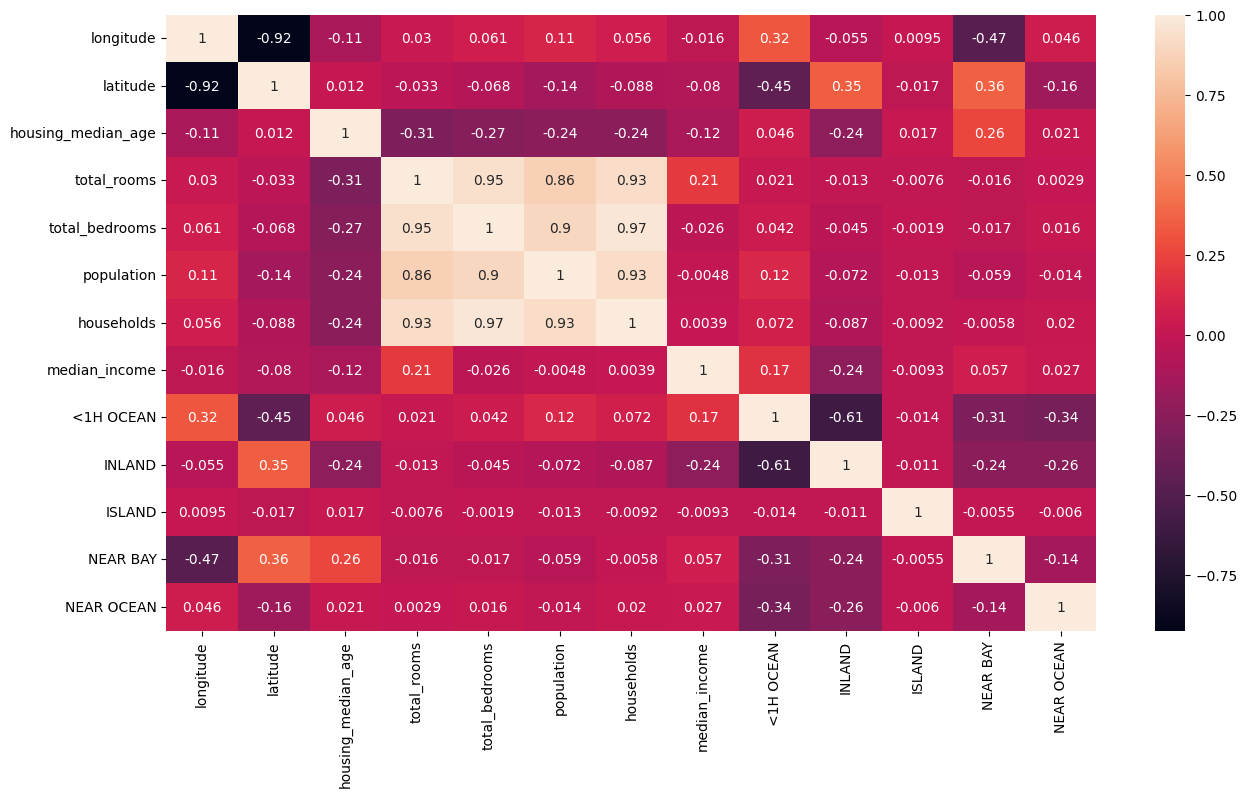

In [21]:
plt.figure(figsize=(15,8))
sns.heatmap(X.corr(),annot=True)

* There is multicollinearity in this data as predictor variables are somewhat correlated to one another. 
* This problem can be solved by using RidgeModel. RidgeModel is a type of linear regression that is used in data set with multicollinearity. 

In [27]:
from sklearn.linear_model import Ridge

In [28]:
# By changing the values of alpha, we are controlling the penalty term. 
# The higher the values of alpha, the bigger is the penalty and therefore the magnitude of coefficients is reduced.
RidgeModel = Ridge(alpha=0.1,normalize=True)

In [29]:
RidgeModel.fit(X_train,y_train)

Ridge(alpha=0.1, normalize=True)

In [30]:
RidgeModel.score(X_test,y_test)

0.6391332534906973

#### We will try using Polynomial features to transform data to see if we will obtain better model

In [31]:
from sklearn.preprocessing import PolynomialFeatures

In [32]:
pr = PolynomialFeatures(degree=2)

X_train_pr = pr.fit_transform(X_train)
X_test_pr = pr.transform(X_test)

In [33]:
RidgeModel.fit(X_train_pr,y_train)

Ridge(alpha=0.1, normalize=True)

In [34]:
RidgeModel.score(X_test_pr,y_test)

0.6749179550462742

* In conclusion, after multicollinearity is addressed and polynomial data transforming is applied, the model yields better results. The median house price can be 67% accurately estimated based on the combination of various factors. 

* However, 67% is not too good. We need a model that can predict house price with more than 90% accuracy. 

* The next model we will use on this data is Random Forest

## Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
                           

In [45]:
rf.fit(X_train,y_train)

RandomForestRegressor()

In [46]:
rf.score(X_test,y_test)

0.827232520242038

In [47]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('rf', RandomForestRegressor())
])

grid_params = [{

    'rf__n_estimators' : [25,50,100,150],
    'rf__max_features' : ['sqrt','log2',None],
    'rf__min_samples_split' : [2,4,6,8]
    
    
}]

grid_search = GridSearchCV(pipeline,
                           param_grid= grid_params,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

# accuracy score can't be used in regression model

In [48]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('rf', RandomForestRegressor())]),
             param_grid=[{'rf__max_features': ['sqrt', 'log2', None],
                          'rf__min_samples_split': [2, 4, 6, 8],
                          'rf__n_estimators': [25, 50, 100, 150]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [50]:
best_rf = grid_search.best_estimator_

In [51]:
best_rf

Pipeline(steps=[('scale', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_features=None, min_samples_split=4,
                                       n_estimators=150))])

In [56]:
pred_1 = rf.predict(X_test)

In [57]:
RMSE_1 = sqrt(mean_squared_error(y_test,pred_1))
RMSE_1

48606.85671425524

In [55]:
best_rf.score(X_test,y_test)

0.8265284402404607

* After trying different combinations of params grid for hyperparameter tuning, we conclude that the original random forest with n_estimators = 100 yields the most optimal result. Hence, we will use the random forest model before tuning to predict median house value. 
* This model can predict median house value 82.72% correctly. The RMSE of this model is also lower than the RMSE of linear regression model. In short, Random Forest yields more accurate predictions compared to the linear regression model. However, we want to test another model to see if we can predict the median house value more than 90% accuracy. 
* Another model we will test in K-Nearest Neighbors. 

## kNN

In [58]:
from sklearn.neighbors import KNeighborsRegressor

In [59]:
model = KNeighborsRegressor(n_neighbors=8)
print(model)

KNeighborsRegressor(n_neighbors=8)


In [60]:
model.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=8)

In [61]:
pred_2 = model.predict(X_test)

In [62]:
model.score(X_test,y_test)

0.6817317193627874

In [64]:
RMSE_2 = sqrt(mean_squared_error(y_test,pred_2))
RMSE_2

65972.54183506017

## Conclusion

* After training and testing the 3 models - Linear Regression, Random Forest, and k-Nearest-Neighbors (kNN), we conclude that Random Forest is the best model for this business problem. kNN with 100 estimators can predict the median house value 82.72% correctly. This model aslo has the lowerst RMSE (root mean squared error) among the three models. 
* That said, none of the three model can yield prediction more than 90% correctly, which means that the company may need to factor in more predictors or drop some unncessary predictors. 
